# __Machine Learning for Prioritizing Blood Pressure Genes__ 

In [1]:
import re

import numpy as np
import pandas as pd
from numpy import sort

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

import seaborn as sns
import shap
import statsmodels.api as sm

%matplotlib inline
%config InlineBackend.figure_format ='retina'
import statsmodels.stats.api as sms
import xgboost
from missingpy import MissForest
from sklearn import datasets, metrics, model_selection, preprocessing
from sklearn.metrics import (
    explained_variance_score,
    max_error,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    RandomizedSearchCV,
    RepeatedKFold,
    cross_val_predict,
    cross_val_score,
    cross_validate,
    learning_curve,
    train_test_split,
    validation_curve,
)

sns.set_style("darkgrid")
sns.mpl.rcParams["figure.figsize"] = (15.0, 9.0)

import warnings

import matplotlib
import matplotlib.pyplot as plt

warnings.simplefilter(action="ignore", category=FutureWarning)
from warnings import filterwarnings

filterwarnings("ignore")

seed = 0

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.


In [2]:
data = pd.read_csv("training_cleaned.csv", header=0, sep=",")

In [3]:
data["BPlabel_encoded"] = data["BPlabel"].map(
    {"most likely": 1, "probable": 0.75, "least likely": 0.1}
)
Y = data["BPlabel_encoded"]
data = data.drop(["BPlabel"], 1)
data.shape

(293, 22)

### Load Boruta Shap Selected Features

In [4]:
X = pd.read_csv("selected_features_training_data.csv", header=0)
X.columns = [
    regex.sub("_", col) if any(x in str(col) for x in set(("[", "]", "<"))) else col
    for col in X.columns.values
]

In [5]:
df_gene = data[["Gene"]]

X = pd.concat([df_gene, X], axis=1)

X = X.set_index("Gene")

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

### Optimized Model:
- xgb (gradient boosting regression) model with set parameters used for the rest of the code

In [7]:
xgb = xgboost.XGBRegressor(
    n_estimators=40,
    learning_rate=0.2,
    max_depth=4,
    reg_alpha=1,
    reg_lambda=1,
    random_state=seed,
    objective="reg:squarederror",
)

### Training Data Prediction Visualization:

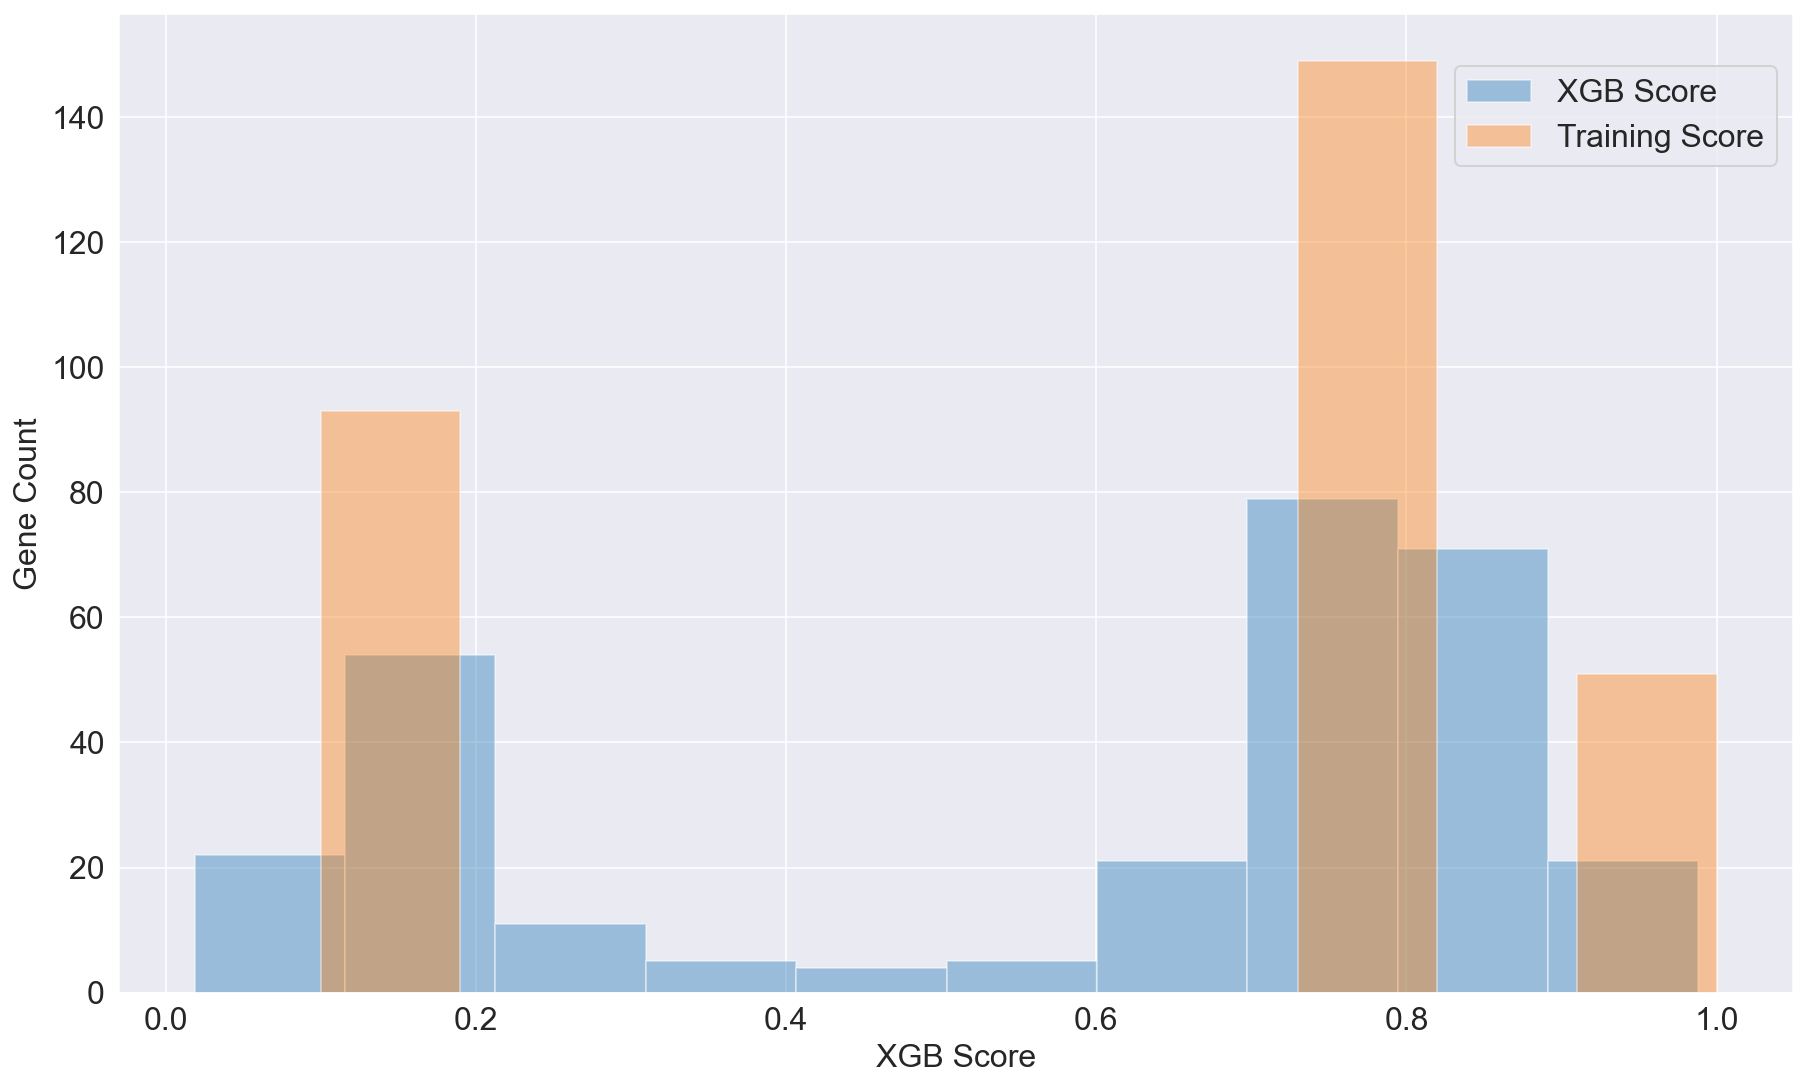

In [8]:
xgb.fit(X, Y)
predictions = list(xgb.predict(X))

output = pd.Series(data=predictions, index=X.index, name="XGB_Score")

df_total_training = pd.concat([X, output], axis=1)

df_total = pd.concat([X, output], axis=1)

fig, ax = plt.subplots()

sns.distplot(df_total["XGB_Score"], ax=ax, kde=False, norm_hist=False, bins=10)
sns.distplot(Y, ax=ax, kde=False, bins=10)
fig.legend(
    labels=["XGB Score", "Training Score"],
    loc="upper right",
    bbox_to_anchor=(0.83, 0.8),
    ncol=1,
    fontsize=16,
)
ax.set_xlabel("XGB Score", fontsize=16)
ax.set_ylabel("Gene Count", fontsize=16)
ax.tick_params(labelsize=16)

In [9]:
predictions = list(xgb.predict(X))

output = pd.Series(data=predictions, index=X.index, name="XGB_Score")

output = output.to_frame()
output.reset_index(level=0, inplace=True)

In [11]:
df_b = data[["BPlabel_encoded"]]

df_c = pd.concat([output, df_b], axis=1)
df_c.to_csv("xgb_training_evangelou.csv", index=False)
df_c

,Gene,XGB_Score,BPlabel_encoded
0,ABCC9,0.980824,1.00
1,AC006455.1,0.125451,0.10
2,AC007216.2,0.117344,0.10
3,AC007461.1,0.116189,0.10
4,AC008498.1,0.143057,0.10
...,...,...,...
288,YES1,0.866477,0.75
289,Z98049.1,0.116189,0.10
290,ZAP70,0.760145,0.75
291,ZMYM6NB,0.117941,0.10


## Overview of SHAP feature importance:
- Further invesitgation into SHAP visualization of training data continued in the next script (SHAP_Random-Forest-BPGWASPredict.ipynb)

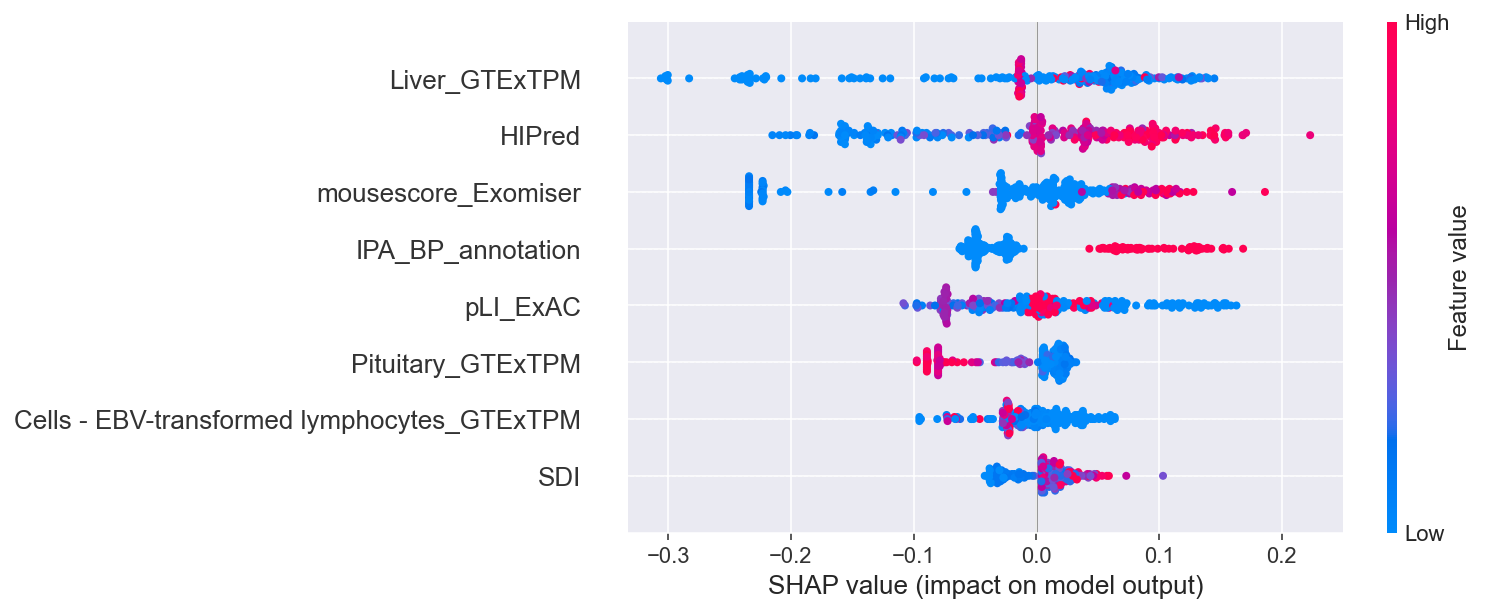

In [20]:
xgb.fit(X, Y)
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

### Unknown gene prediction by the trained model:

In [21]:
dataset_unknown = pd.read_csv("predicted_data.txt", sep="\t")
dataset_unknown = dataset_unknown.rename({'IPA_BP':'IPA_BP_annotation'}, axis=1)
df2 = dataset_unknown[
    [
        "SDI",
        "Liver_GTExTPM",
        "Cells - EBV-transformed lymphocytes_GTExTPM",
        "Pituitary_GTExTPM",
        "pLI_ExAC",
        "mousescore_Exomiser",
        "HIPred",
        "IPA_BP_annotation",
    ]
]

df2.shape

(1804, 8)

In [22]:
imputer = MissForest(random_state=seed)
df3 = imputer.fit_transform(df2)

Iteration: 0
Iteration: 1
Iteration: 2


In [23]:
X2 = pd.DataFrame(df3, index=df2.index, columns=df2.columns)
X2.shape

(1804, 8)

In [24]:
model = xgb
model.fit(X, Y)
predictions = list(model.predict(X2))

output = pd.Series(data=predictions, index=dataset_unknown.index, name="XGB_Score")

df_total = pd.concat([dataset_unknown, output], axis=1)

In [25]:
df_total.nlargest(10, "XGB_Score", keep="last")

,Gene,REVEL.max,MetaSVM_rankscore.max,MetaLR_rankscore.max,MCAP.max,wgEncodeBroadHmmHuvecHMM.count,betamax,logpval_gwascatalog,Adipose - Subcutaneous_GTExTPM,Adipose - Visceral (Omentum)_GTExTPM,...,MetaLR_rankscore,MetaSVM_rankscore,MutationAssessor_rankscore,REVEL_score,fathmm-MKL_coding_score,integrated_fitCons_rankscore,LoFtool,GERP_Rankscore,BPlabel,XGB_Score
331,COL15A1,0.412,0.876,0.880,NaN,33,-0.3010,23.30103,126.192000,75.095400,...,NaN,NaN,NaN,NaN,NaN,NaN,0.232,NaN,unknown,0.977636
1505,SMOC2,NaN,NaN,NaN,NaN,230,-0.4184,22.30103,75.416100,71.252200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown,0.957912
827,MLIP,0.000,0.354,0.075,NaN,10,-0.1964,13.00000,0.673251,0.293427,...,0.48084,0.63282,0.97045,0.508,0.98749,0.97801,0.280,0.81769,unknown,0.956034
1444,SGCD,NaN,NaN,NaN,NaN,280,0.2110,10.00000,3.075140,2.000780,...,NaN,NaN,NaN,NaN,NaN,NaN,0.276,NaN,unknown,0.945889
306,CHRM2,NaN,NaN,NaN,NaN,494,0.4323,12.00000,0.004196,0.023050,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown,0.940262
329,COG2,0.110,0.339,0.006,NaN,796,-0.3285,5.09691,14.409000,11.299500,...,NaN,NaN,NaN,NaN,NaN,NaN,0.854,NaN,unknown,0.931486
463,ELK3,NaN,NaN,NaN,NaN,21,-0.4724,10.69897,58.474600,48.517600,...,0.20672,0.30227,NaN,0.006,0.01204,0.37627,NaN,0.03257,unknown,0.929442
1513,SNTB2,0.106,NaN,NaN,NaN,15,-0.1717,12.30103,22.574200,16.015500,...,0.96265,0.94265,0.82220,0.775,0.97777,0.81865,0.905,0.69459,unknown,0.928734
114,ARHGEF26,0.456,0.792,0.653,NaN,222,0.6269,10.00000,10.389700,7.280710,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown,0.921314
1171,PTPN3,0.354,0.331,0.000,NaN,25,-0.2487,9.39794,3.491070,3.822930,...,0.63929,0.64722,0.50145,0.251,0.99233,0.92422,0.485,0.91077,unknown,0.920013


In [23]:
df10 = df_total.nlargest(10, "XGB_Score", keep="last")
df10.to_csv("Top10Genes.csv", index=False)

In [26]:
df10 = df_total.nlargest(10, "XGB_Score", keep="last")
df10 = df10[
    [
        "Gene",
        "SDI",
        "Liver_GTExTPM",
        "Cells - EBV-transformed lymphocytes_GTExTPM",
        "Pituitary_GTExTPM",
        "pLI_ExAC",
        "mousescore_Exomiser",
        "HIPred",
        "IPA_BP_annotation",
    ]
]

df10.to_csv("Top10Genes_SelectedFeatures.csv", index=False)

In [27]:
df_file = df_total[["Gene", "XGB_Score"]]
df_file = df_file.nlargest(1804, "XGB_Score", keep="last")
df_file.to_csv("BPgene_ranking_xgb_evangelou.txt", index=False)

### Overview of SHAP feature importance:

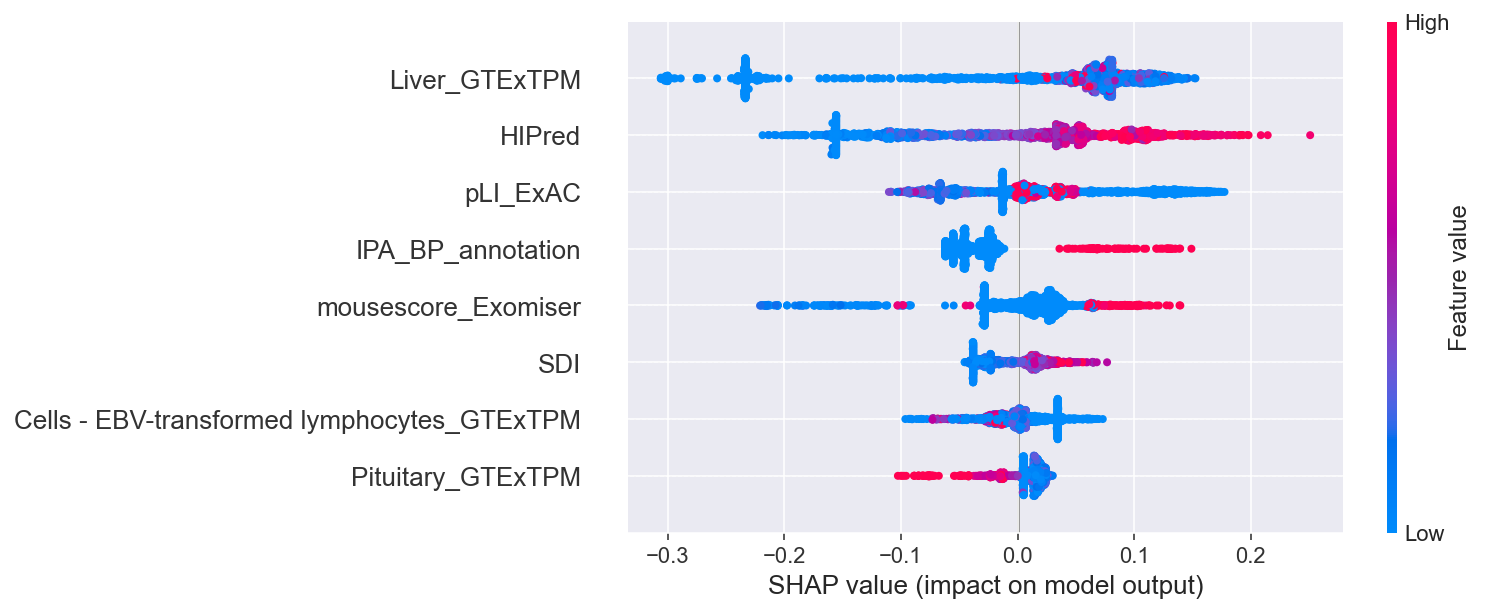

In [28]:
df3 = pd.DataFrame(data=X2, columns=X2.columns)
df3.columns = [
    regex.sub("_", col) if any(x in str(col) for x in set(("[", "]", "<"))) else col
    for col in X.columns.values
]
X_importance = X2
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)
X_importance = pd.DataFrame(data=X2, columns=df3.columns)
shap.summary_plot(shap_values, X_importance)